Attention: Config code at the beginning of next cell!

<link rel="stylesheet" href="custom_style_addon.css">

<div align="center">
<br><br><br>
<a href="https://messo.cit.ie/draf" title="Link to Draf homepage.">
    <img src="pics/all.svg" alt="drawing" width="400">
</a>
<br><br><br>
<h1 style="font-size:200%; text-align:center"> Welcome to the showcase! </h1>
</div>

<hr />

<div style="font-size:55%; text-align:center; color:#b0b0b0" align=center>
<b>Navigation:</b>
Slides: <code>Page-up</code> / <code>Page-down</code> | 
Chapters: <code>←</code> / <code>→</code> | 
Subslides: <code>↑</code> / <code>↓</code> | 
Overview: <code>Esc</code> <br> <br>
<b>Draf</b> (<b>d</b>emand <b>r</b>esponse <b>a</b>nalysis <b>f</b>ramework) is a modular framework that enables the economic and ecological evaluation of industrial demand response. It is developed by <a href="https://www.linkedin.com/in/markus-fleschutz/">Markus Fleschutz</a> in a cooperative PhD between <a href="https://www.cit.ie/">Cork Institute of Technology</a> and the <a href="https://www.hs-karlsruhe.de/en/">Karlsruhe University of Applied Sciences</a> and under the supervision of <a href="https://ie.linkedin.com/in/michael-d-murphy-16134118">Dr. Michael D. Murphy</a> and <a href="https://www.hs-karlsruhe.de/w/ueber-uns/personen/professorinnen/prof-dr-ing-marco-braun/">Dr.-ing Marco Braun</a>.
</div>

# Why draf?

- Price based demand response is an essential and promising approach to increase the power system's operational flexibility and reduce cost and carbon emissions for an industrial company.
- However, the quantification of the demand response potential requires the modeling of the market and the flexible entities together with its main constraints.
- **Draf makes all this very easy.**

Here are some key features:
- Intuitive handling of complex data structures.
- Uses the power of gurobi, the fastest MILP solver available and its community for model formulation and solving (Its free for academic use 🎓😀).
- Easy and automatic scenario generation and sensitivity analyses.
- Naming conventions for parameters and variables.
- Electricity prices, generation data, load etc. are downloaded on demand and cached for later use.
- Ecological assessment uses dynamic carbon emission factors calculated from historic national electric generation data.
- Economic assessment uses historic day-ahead market prices.
- Modules for load profile creation.
- Convenient plotting.
- Automatic unit conversion, great descriptions and documentation.
- Partly tested, uses Python's modern type annotations.
- Whole case studies and individual scenarios can be saved including all results.

# Define a simple model
Let's say you want to know the economic and ecological demand response potential of a 1 MWh Battery Energy System (BES) under consideration of a 100kW_peak Photovoltaic (PV) system, a 50 €/kW capacity price for electricity and a given electricity demand.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# These are the only imports you need.
from gurobipy import GRB, quicksum
import draf

In [3]:
def params_func(sc):
    """Defines model parameters and variables with bounds, type, units, descriptions, etc."""
    p = sc.params
    T = sc.add_dim("T", infer=True)
    sc.add_par(name="alpha_", data=0, doc="pareto weighting factor", unit="")
    sc.prep.add_n_comp_()
    sc.add_par("n_C_", 1e4, "normalization factor", "")
    sc.add_par("n_CE_", 1, "normalization factor", "")
    sc.add_par("AF_", 0.1, "annuitiy factor (it pays off in 1/AF_ years)", "")
    doc_CAPx = "existing capacity"
    sc.add_par("P_PV_CAPx_", 0, doc_CAPx, "kW_peak")
    sc.add_par("E_BES_CAPx_", 0, doc_CAPx, "kW_el")
    sc.add_par("c_el_peak_", 40, "peak price", "€/kW_el")
    rtp = sc.prep.add_c_el_RTP_T()
    tou = sc.prep.add_c_el_TOU_T()
    flat = sc.prep.add_c_el_FLAT_T()
    sc.add_par("c_el_T", rtp, "chosen electricity tariff", "€/kWh_el")
    sc.prep.add_c_el_addon_T()
    sc.prep.add_ce_el_T()
    sc.prep.add_E_PV_profile_T()
    sc.prep.add_E_dem_T(profile="G3", annual_energy=5e5)
    sc.add_par("eta_BES_time_", .999, "storing efficiency", "")
    sc.add_par("eta_BES_in_", .999, "loading efficiency", "")
    sc.add_par("k_BES_in_per_capa_", 1, "ratio loading power / capacity", "")
    sc.add_var("C_", "operating costs", "€/a", lb=-GRB.INFINITY)
    sc.add_var("CE_", "operating emissions", "gCO2eq/a", lb=-GRB.INFINITY)
    sc.add_var("E_pur_T", "purchased electricity", "kWh_el", lb=-GRB.INFINITY)
    sc.add_var("E_PV_T", "produced el.", "kWh_el")
    sc.add_var("E_PV_OC_T", "own consumption", "kWh_el")
    sc.add_var("E_PV_FI_T", "feed-in", "kWh_el")
    sc.add_var("E_BES_T", "el. stored", "kWh_el")
    sc.add_var("E_BES_in_T", "loaded el.", "kWh_el", lb=-GRB.INFINITY)
    sc.add_var("E_BES_in_max_", "maximum loading rate el.", "kWh_el")
    sc.add_var("E_BES_out_max_", "maximum unloading rate el.", "kWh_el")
    sc.add_var("E_pur_T", "purchased el.", "kWh_el")
    sc.add_var("E_sell_T", "purchased el.", "kWh_el")
    sc.add_var("P_pur_peak_", "peak el.", "kW_el")

In [4]:
def model_func(m, d, p, v):
    """Sets model constraints. Arguments: (m)odel, (d)imensions, (p)arameters, and (v)ariables."""
    T = d.T
    m.setObjective(((1 - p.alpha_) * v.C_ * p.n_C_ + p.alpha_ * v.CE_ * p.n_CE_), GRB.MINIMIZE)
    m.addConstr(
        v.C_ == (v.P_pur_peak_ * p.c_el_peak_ +
                 p.n_comp_ * quicksum(v.E_pur_T[t] *
                                      (p.c_el_T[t] + p.c_el_addon_T[t]) - v.E_sell_T[t] *
                                      p.c_el_T[t] for t in T)), "DEF_C_op")
    m.addConstr(v.CE_ == p.n_comp_ * quicksum(v.E_pur_T[t] * p.ce_el_T[t] for t in T), "DEF_CE_op_")
    m.addConstrs((v.E_pur_T[t] + v.E_PV_OC_T[t] == p.E_dem_T[t] + v.E_BES_in_T[t] for t in T),
                 "BAL_el")
    m.addConstrs((v.E_sell_T[t] == v.E_PV_FI_T[t] for t in T), "DEF_E_sell")
    m.addConstrs((v.E_pur_T[t] <= v.P_pur_peak_ for t in T), "DEF_peakPrice")
    m.addConstrs((v.E_PV_T[t] == p.P_PV_CAPx_ * p.E_PV_profile_T[t] for t in T), "PV1")
    m.addConstrs((v.E_PV_T[t] == v.E_PV_FI_T[t] + v.E_PV_OC_T[t] for t in T), "PV_OC_FI")
    m.addConstrs(
        (v.E_BES_T[t] == p.eta_BES_time_ * v.E_BES_T[t - 1] + p.eta_BES_in_ * v.E_BES_in_T[t]
         for t in T[1:]), "BAL_BES")
    m.addConstrs((v.E_BES_T[t] <= p.E_BES_CAPx_ for t in T), "MAX_BES_E")
    m.addConstrs((v.E_BES_in_T[t] <= v.E_BES_in_max_ for t in T), "MAX_BES_IN")
    m.addConstrs((v.E_BES_in_T[t] >= -v.E_BES_out_max_ for t in T), "MAX_BES_OUT")
    m.addConstr(v.E_BES_in_max_ == p.E_BES_CAPx_ * p.k_BES_in_per_capa_, "DEF_E_BES_in_max_")
    m.addConstr(v.E_BES_out_max_ == p.E_BES_CAPx_ * p.k_BES_in_per_capa_, "DEF_E_BES_out_max_")
    m.addConstrs((v.E_BES_T[t] == 0 for t in [min(T), max(T)]), "INI_BES")

In [5]:
def postprocess_func(r):
    """Ensures positive timeseries for sankey- and log-based plots."""
    r.make_pos_ent("E_BES_in_T", "E_BES_out_T")
    r.make_pos_ent("E_pur_T")

# Set up a case study and generate scenarios

In [6]:
cs = draf.CaseStudy("ShowCase", year=2017, freq="60min", country="DE")
cs.set_custom_datetimeindex(t_st="Jan-01 00", t_end="Dec-31 23")

cs.add_REF_scen(doc="no BES").set_params(params_func).update_params(P_PV_CAPx_=100, c_el_peak_=50)
cs.add_scens([("c_el_T", "t", [f"c_el_{ix}_T" for ix in ["RTP", "TOU", "FLAT"]]),
              ("E_BES_CAPx_", "b", [1000])],
             nParetoPoints=4)

cs.improve_pareto_and_set_model(model_func)
cs.optimize(postprocess_func, logToConsole=False, show_results=False)
cs.save();

Using license file D:\Programme\Anaconda3\gurobi.lic
Academic license - for non-commercial use only
Successfully solved 13 scenarios with an average solving time of 0.675 seconds.
CaseStudy saved to D:/mf/draf/results/ShowCase/2019-12-02_163314_.p ( 37.0 MB)


In [7]:
cs

<CaseStudy object>
• name: ShowCase
• doc: No doc available.
• freq: 60min
• country: DE
• is_dry_run: False
• scens: [...]
• plot: <draf.plotting.cs_plotting.CsPlotter object at 0x000001C0AD6482C8>
• dims: <Dimensions object> (empty)
• params: <Params object> (empty)
• obj_vars: ['C_', 'CE_']
• year: 2017
• dtindex: [...]
• dtindex_custom: [...]
• steps_per_day: 24
• scen_vars: [('c_el_T', 't', ['c_el_RTP_T', 'c_el_TOU_T', 'c_el_FLAT_T']), ('E_BES_CAPx_', 'b', [1000]), ('alpha_', 'a', array([0.        , 0.33333333, 0.66666667, 1.        ]))]
• scen_df: [...]
• dt_info:
  ⤷ t1 = 0     (Sunday, 2017-01-01 00:00:00),
  ⤷ t2 = 8375  (Friday, 2017-12-15 23:00:00)
  ⤷ Length = 8376

In [8]:
cs.scens

<Scenarios object>
   name         doc
  ⤷ REF        | no BES
  ⤷ sc1        | c_el_T=c_el_RTP_T; E_BES_CAPx_=1000; alpha_=0.0
  ⤷ sc2        | c_el_T=c_el_RTP_T; E_BES_CAPx_=1000; alpha_=0.3333333333333333
  ⤷ sc3        | c_el_T=c_el_RTP_T; E_BES_CAPx_=1000; alpha_=0.6666666666666666
  ⤷ sc4        | c_el_T=c_el_RTP_T; E_BES_CAPx_=1000; alpha_=1.0
  ⤷ sc5        | c_el_T=c_el_TOU_T; E_BES_CAPx_=1000; alpha_=0.0
  ⤷ sc6        | c_el_T=c_el_TOU_T; E_BES_CAPx_=1000; alpha_=0.3333333333333333
  ⤷ sc7        | c_el_T=c_el_TOU_T; E_BES_CAPx_=1000; alpha_=0.6666666666666666
  ⤷ sc8        | c_el_T=c_el_TOU_T; E_BES_CAPx_=1000; alpha_=1.0
  ⤷ sc9        | c_el_T=c_el_FLAT_T; E_BES_CAPx_=1000; alpha_=0.0
  ⤷ sc10       | c_el_T=c_el_FLAT_T; E_BES_CAPx_=1000; alpha_=0.3333333333333333
  ⤷ sc11       | c_el_T=c_el_FLAT_T; E_BES_CAPx_=1000; alpha_=0.6666666666666666
  ⤷ sc12       | c_el_T=c_el_FLAT_T; E_BES_CAPx_=1000; alpha_=1.0

In [9]:
cs.scens.REF

<Scenario object>
• id: REF
• name: REF
• doc: no BES
• is_dry_run: False
• dims: [...]
• params: [...]
• mdl: <gurobi.Model Continuous instance REF_copy: 75389 constrs, 58637 vars, Parameter changes: MIPGap=0.1, MIPFocus=1, LogFile=D:\mf\draf\results\ShowCase\gurobi.log, LogToConsole=0>
• plot: <draf.plotting.scen_plotting.ScenPlotter object at 0x000001C0AD648EC8>
• prep: <draf.prep.params_prepping.Prepper object at 0x000001C0AD648E48>
• vars: [...]
• dtindex: [...]
• dtindex_custom: [...]
• res: [...]

In [10]:
cs.scens.REF.params

<Params object>
   name                 dims       unit doc
  ⤷ alpha_                   |          |pareto weighting factor
  ⤷ n_comp_                  |          |weighting factor to compensate part year analysis
  ⤷ n_C_                     |          |normalization factor
  ⤷ n_CE_                    |          |normalization factor
  ⤷ AF_                      |          |annuitiy factor (it pays off in 1/AF_ years)
  ⤷ P_PV_CAPx_               |   kW_peak|existing capacity
  ⤷ E_BES_CAPx_              |     kW_el|existing capacity
  ⤷ c_el_peak_               |   €/kW_el|peak price
  ⤷ c_el_RTP_T              T|  €/kWh_el|Day-ahead-market-prices 2017, 60min, DE
  ⤷ c_el_TOU_T              T|  €/kWh_el|Time-Of-Use-tariff with the prices 0.030€ and 0.043€
  ⤷ c_el_FLAT_T             T|  €/kWh_el|Flat-electricity tariff with the price 0.034€
  ⤷ c_el_T                  T|  €/kWh_el|chosen electricity tariff
  ⤷ c_el_addon_T            T|  €/kWh_el|add-on electricity price component

# Plot results

In [11]:
# produces a table of all scalar parameter of the model.
cs.plot.table("p")

Note: Bold font indicate deviation from first/reference scenario.


,REF,sc1,sc2,sc3,sc4,sc5,sc6,sc7,sc8,sc9,sc10,sc11,sc12,unit,doc
p,,,,,,,,,,,,,,,
alpha_,0,0,0.333333,0.666667,1,0,0.333333,0.666667,1,0,0.333333,0.666667,1,,pareto weighting factor
n_comp_,1.04585,1.04585,1.04585,1.04585,1.04585,1.04585,1.04585,1.04585,1.04585,1.04585,1.04585,1.04585,1.04585,,weighting factor to compensate part year analysis
n_C_,1.39706e-05,1.39706e-05,1.39706e-05,1.39706e-05,1.39706e-05,1.39706e-05,1.39706e-05,1.39706e-05,1.39706e-05,1.39706e-05,1.39706e-05,1.39706e-05,1.39706e-05,,normalization factor
n_CE_,4.31258e-09,4.31258e-09,4.31258e-09,4.31258e-09,4.31258e-09,4.31258e-09,4.31258e-09,4.31258e-09,4.31258e-09,4.31258e-09,4.31258e-09,4.31258e-09,4.31258e-09,,normalization factor
AF_,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,,annuitiy factor (it pays off in 1/AF_ years)
P_PV_CAPx_,100,100,100,100,100,100,100,100,100,100,100,100,100,kW_peak,existing capacity
E_BES_CAPx_,0,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,kW_el,existing capacity
c_el_peak_,50,50,50,50,50,50,50,50,50,50,50,50,50,€/kW_el,peak price
eta_BES_time_,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.999,,storing efficiency


In [12]:
# produces a table of all scalar parameter of the model.
cs.plot.table("v")

Note: Bold font indicate deviation from first/reference scenario.


,REF,sc1,sc2,sc3,sc4,sc5,sc6,sc7,sc8,sc9,sc10,sc11,sc12,unit,doc
v,,,,,,,,,,,,,,,
C_,71579,68615.7,69397.8,72033.8,118380,69178.4,70591.8,74688.6,121595,69743.5,70920.5,74557.4,120901,€/a,operating costs
CE_,2.3188e+08,2.14393e+08,2.01661e+08,1.93333e+08,1.89529e+08,2.29726e+08,2.07428e+08,1.94024e+08,1.89529e+08,2.30842e+08,2.0574e+08,1.93665e+08,1.89529e+08,gCO2eq/a,operating emissions
E_BES_in_max_,0,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,kWh_el,maximum loading rate el.
E_BES_out_max_,0,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,kWh_el,maximum unloading rate el.
P_pur_peak_,75.936,73.8084,97.893,157.082,1074.35,61.7262,76.6205,144.232,1074.35,61.7262,76.1567,145.69,1074.35,kW_el,peak el.


D:\Programme\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



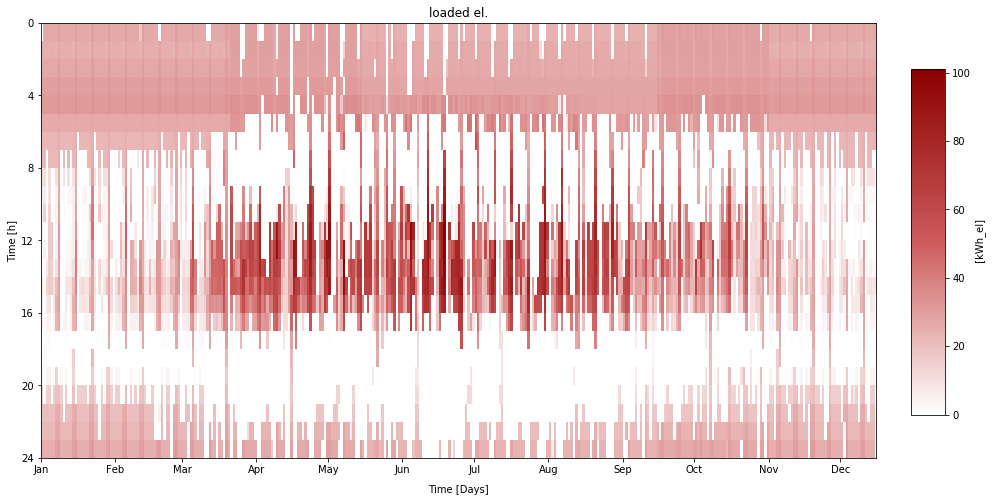

In [13]:
cs.scens.sc1.plot.heatmap(ent_name="E_BES_in_T")

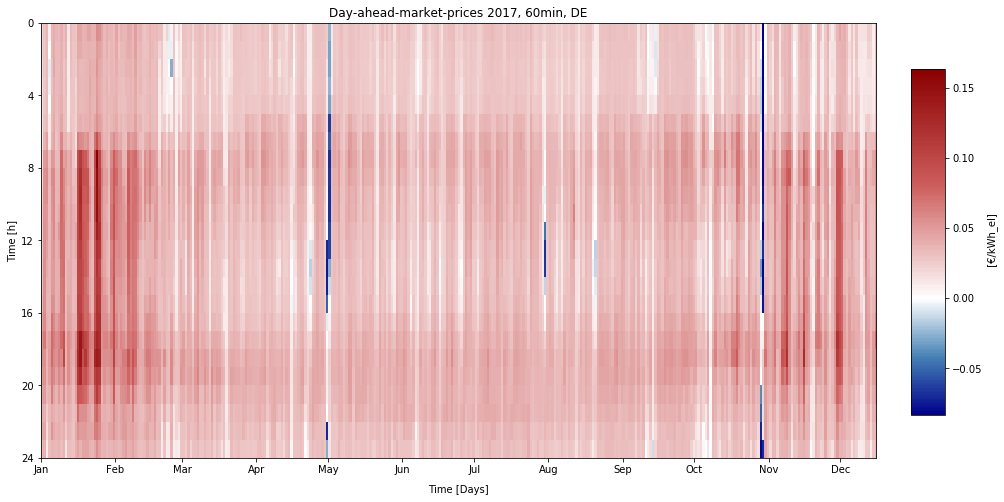

In [14]:
cs.scens.sc1.plot.heatmap(ent_name="c_el_RTP_T")

In [15]:
cs.plot.pareto2(
    c_dict=dict(REF="#606269", FLAT="#F26535", TOU="#FCC706", RTP="#9BAF65"))

In [16]:
# Specifies the energy flows for use in sankey plots.
def sankey_func(sc):
    p = sc.params
    r = sc.res
    return f"""\
    type source target value
    E PUR EL {r.E_pur_T.sum()}
    E PV EL {r.E_PV_OC_T.sum()}
    E PV SELL_el {r.E_PV_FI_T.sum()}
    E EL BES {r.E_BES_in_T.sum()}
    E BES DEM_el {r.E_BES_out_T.sum()}
    E EL DEM_el {p.E_dem_T.sum()- r.E_BES_in_T.sum()}
    """

cs.scens.sc1.plot.sankey(sankey_func)
# Note: Press F5 to update output.

In [17]:
cs.plot.big_plot(sankey_func)

In [54]:
cs.REF_scen.plot.heatmap()

Exception: No timeseries specified!

In [53]:
cs.plot.heatmap_interact("v", "T")

interactive(children=(Dropdown(description='scen_name', options=('REF', 'sc1', 'sc2', 'sc3', 'sc4', 'sc5', 'sc…

FigureWidget({
    'data': [{'type': 'heatmap',
              'uid': '83390369-9fec-4779-b37d-62fb80e8f8a2',
 …

In [52]:
!jupyter nbconvert --to slides index.ipynb --SlidesExporter.reveal_scroll=True --SlidesExporter.reveal_transition=convex
#--SlidesExporter.reveal_theme=serif
!del index.html
!rename index.slides.html index.html

[NbConvertApp] Converting notebook index.ipynb to slides
[NbConvertApp] Writing 539436 bytes to index.slides.html
